# Smart feature selection with sklearn pipelines, feature-engine, and probatus

* Gilles Verbockhaven (gilles.verbockhaven@ing.com)
* Ryan Chaves (ryan.chaves@ing.com)

## Feature elimination w/ `probatus`

This notebook is based in part on an internal ING Code Breakfast workshop prepared by our RPAA Team colleagues João Pinto Moura (joao.pinto.moura@ing.com) and Tingting Qiao (tingting.qiao@ing.com). Kudos!

After removing features based on quality (or stability) criteria, some work still needs to be done since many features will only have a marginal (or even no) contribution to the final prediction.

It is therefore considered best practice to reduce the size of the feature set. This is a trade-off between the number of features (model complexity) and model performance.

### Import and create a data set 

(Nearly the same as for the previous notebook)

#### Setup & import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#### Function to generate a toy data set

We start by generating a data set that has many of the most commonly-encountered issues:

- 8 informative features (`n_informative=8`)
- 2 features are duplicates of others (`n_repeated=2`)
- 2 features have a high correlation with others (`n_redundant=2`)
- 2 features have no relation with the target (`n_features - (n_informative + n_redundant + n_repeated)`)
- 1 constant feature (`fconst`)

We will now introduce you to a few "selectors" that are able to automatically find and drop the less relevant features.

In [2]:
def make_df(n_samples, n_features, n_informative, n_redundant, n_repeated):
    # Define number of features in the data set
    feature_names = [f'f{idx}' for idx in range(1, n_features+1)]

    # Prepare toy data set
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, 
                               n_redundant=n_redundant, n_repeated=n_repeated, n_clusters_per_class=1, random_state=42)

    X = pd.DataFrame(X, columns=feature_names)
    # Add a constant feature
    X = X.assign(fconst='21')

    # Split the dataset into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = make_df(n_samples=200, n_features=14, n_informative=8, n_redundant=2, n_repeated=2)

In [4]:
X_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,fconst
169,-0.800315,2.920142,-0.800315,-1.557496,-2.193671,1.782765,1.898904,-0.028084,-2.198277,1.403814,-1.557496,-0.909287,-1.833341,-0.818953,21
97,1.559896,1.078386,1.559896,-2.032555,1.408807,2.734227,1.772320,0.228982,3.585245,1.613553,-2.032555,-3.344683,-0.093434,-0.626849,21
31,2.126218,0.242483,2.126218,2.253564,0.229970,0.573055,-2.632417,-0.747078,2.633389,1.391635,2.253564,0.389168,-0.409961,-1.393621,21
12,0.301793,-0.626603,0.301793,1.528372,0.043343,1.110351,-1.722398,0.216317,-1.656465,2.169365,1.528372,1.804543,2.017908,-1.348882,21
35,-3.687436,2.065014,-3.687436,1.305344,0.816032,-2.413883,-4.085517,-0.180490,2.962884,2.746081,1.305344,-0.150293,0.377351,1.050447,21


### Recursive feature elimination

[Recursive feature elimination (RFE)](https://scikit-learn.org/stable/modules/feature_selection.html#rfe) is a feature selection strategy that consists of the following steps:

1. Fit a model using all features available.
2. Measure the feature importance.
3. Eliminate (drop) the features with the least importance (a fixed number, or percentage) from the feature list.
4. Go to #1 and repeat until the number of features is small enough.

There are multiple classes available for RFE.
For example:

- [`Scikit-learn`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection): 
  - Recursive feature elimination (RFE)
  - Recursive feature elimination with cross-validation (RFECV)
  - `SelectFromModel` feature selection
  - Sequential Feature Selection (SFS)

- [`Feature-engine`](https://feature-engine.readthedocs.io/en/1.1.x/selection/index.html):
  - `RecursiveFeatureElimination`
  - `RecursiveFeatureAddition`

- [`Probatus`](https://github.com/ing-bank/probatus)
  - At ING RPAA, we maintain an open-source package which provides handy functions for feature selection.
  - [`ShapRFECV`](https://ing-bank.github.io/probatus/tutorials/nb_shap_feature_elimination.html) is similar to `sklearn.feature_selection.RFECV`, but it uses SHAP to measure feature importance. It also supports early stopping for XGBoost, LightGBM and CatBoost.
  - [SHAP](https://github.com/slundberg/shap#readme) can measure the Shapley values for a variety of models to estimate the contribution of each feature to the model output and, therefore, their importance to the model.

Below we use `probatus.feature_elimination.ShapRFECV`.

At each iteration, this class will fit a `RandomForestClassifier` with 3-fold cross-validation (`cv=3`).

It will measure the feature importance using SHAP and drop the lowest 20% of features (`step=0.2`).

*What is the added value of ShapRFECV? Read our Medium blog post:*

https://medium.com/ing-blog/open-sourcing-shaprfecv-improved-feature-selection-powered-by-shap-994fe7861560

In [5]:
from probatus.feature_elimination import ShapRFECV
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Initiate a classifier
estimator = RandomForestClassifier(max_depth=3, random_state=42)

# Set up a feature eliminator
shap_feature_eliminator = ShapRFECV(clf=estimator, step=0.2, cv=3, scoring='roc_auc')

# Fit and compute the SHAP feature eliminator
report = shap_feature_eliminator.fit_compute(X_train, y_train)

`ShapRFECV` provides a handy tool to plot the train and validation scores as a function of the number of features.
The results typically have the following patterns:

- As the number of features decreases, initially the model performance is stable, since we are dropping features that do not contribute substantially to the model output.
- The overfit (difference between train and validation scores) typically decreases with lower number of features.
- Sometimes the performance shows a slight increase as multi-colinear features are dropped.
- Finally, as the most predictive features are dropped, the performance decreases abruptly. 

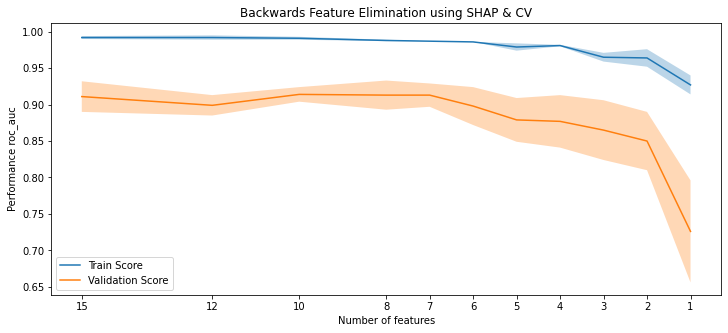

In [9]:
# Visulize the feature elimination process 
performance_plot = shap_feature_eliminator.plot(figsize=(12,5))

There are no hard guidelines on which number of features you should pick for your model.

The results of RFE usually need to be manually analysed, and the decision is typically due to a combination of technical and business reasons (e.g. burden of monitoring large number of features in production).

When discussing the results in detail, you can also look at which features are kept at each RFE step:

In [11]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,15,"[f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11,...","[f10, f13, fconst]",0.992,0.002,0.911,0.021
2,12,"[f9, f12, f11, f7, f2, f4, f6, f3, f14, f1, f5...","[f2, f7]",0.992,0.003,0.899,0.014
3,10,"[f9, f11, f12, f4, f6, f3, f14, f1, f5, f8]","[f6, f8]",0.991,0.002,0.914,0.010
4,8,"[f9, f11, f12, f4, f3, f14, f1, f5]",[f9],0.988,0.001,0.913,0.020
5,7,"[f12, f11, f4, f3, f14, f1, f5]",[f3],0.987,0.000,0.913,0.016
6,6,"[f12, f11, f4, f14, f1, f5]",[f14],0.986,0.000,0.898,0.026
7,5,"[f12, f11, f4, f1, f5]",[f11],0.979,0.005,0.879,0.030
8,4,"[f1, f4, f5, f12]",[f1],0.981,0.001,0.877,0.036
9,3,"[f4, f5, f12]",[f12],0.965,0.006,0.865,0.041
10,2,"[f4, f5]",[f4],0.964,0.012,0.850,0.040


In [10]:
# Want to take a closer look and discuss with business?
report[['num_features', 'features_set', 'val_metric_mean']]

,num_features,features_set,val_metric_mean
1,15,"[f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11,...",0.905
2,12,"[f13, f1, f11, f9, f12, f3, f6, f5, f7, f8, f1...",0.916
3,10,"[f8, f1, f11, f12, f9, f5, f6, f3, f14, f4]",0.912
4,8,"[f1, f9, f11, f12, f5, f3, f14, f4]",0.913
5,7,"[f1, f9, f11, f12, f5, f3, f4]",0.912
6,6,"[f1, f11, f12, f5, f3, f4]",0.891
7,5,"[f1, f12, f5, f3, f4]",0.888
8,4,"[f1, f12, f3, f5]",0.869
9,3,"[f12, f3, f5]",0.879
10,2,"[f3, f5]",0.829


Handy `get_reduced_features_set` function:

In [15]:
# Get final feature set (imagine business is happy with 8 features in production)
final_features_set = shap_feature_eliminator.get_reduced_features_set(num_features=7)
print(f"Here you go, these are the features selected by you and business:\n{final_features_set}")

Here you go, these are the features selected by you and business:
['f12', 'f11', 'f4', 'f3', 'f14', 'f1', 'f5']


#### What does the plot look like in a real case?

![real_case_plot](../pictures/shap_RFE_real_case.png)

> If you want to know more about `ShapRFECV`, there's a great [introduction notebook](https://ing-bank.github.io/probatus/tutorials/nb_shap_feature_elimination.html) in the documentation which you follow.

### Please try this at home!

- Build a wrapper to use `ShapRFECV` in a `Pipeline` and add it to the current pipeline.
- Create your own feature selection pipeline using a new data set.

### Final remark

Feature elimination is often a trade-off between model performance and the risk / burden of working with a large number of features. 

- It is important to discuss this trade-off with the stakeholders and ensure they understand what is at stake.
- Stakeholders, model developers, and data experts should be involved in the final decision. 


### Sources

- https://feature-engine.readthedocs.io/en/1.1.x/selection/index.html
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
- https://ing-bank.github.io/probatus/api/feature_elimination.html

Reading:

- https://www.mihaileric.com/posts/feature-selection/
- https://www.kdnuggets.com/2019/10/feature-selection-beyond-feature-importance.html
- https://towardsdatascience.com/2-types-of-duplicate-features-in-machine-learning-2931de6c949b
- https://programmer.group/feature-selection-of-python-sklearner-learning.html
- https://www.r-bloggers.com/2017/01/feature-selection-in-machine-learning-breast-cancer-datasets/
- https://mrtz.org/nips17/#/97
- https://memegenerator.net/instance/80593848/ben-parker-with-many-features-comes-great-feature-selection


End of this notebook.